### Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

In [1]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab data/airline-passengers.csv', parse_dates=['Month'], index_col=0)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


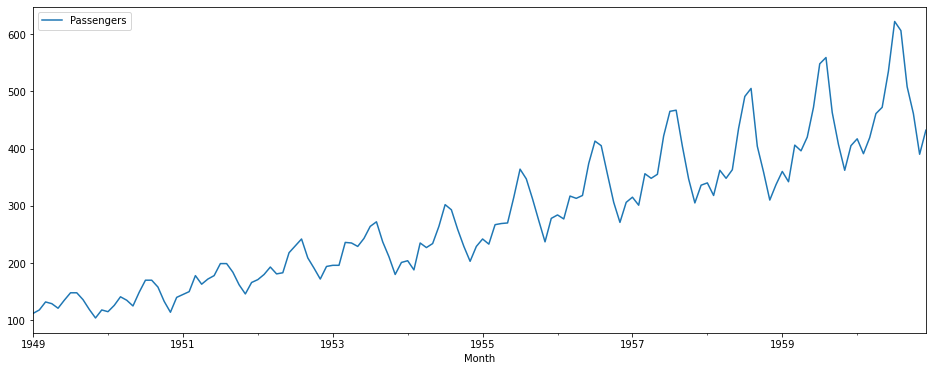

In [3]:
# view data
df.plot(figsize=(16, 6))
plt.show()

In [4]:
df['year'] = df.index.year
df['month'] = df.index.month
# df.reset_index(inplace=True)

print(df.shape)
df.head()

(144, 3)


,Passengers,year,month
Month,,,
1949-01-01,112,1949,1
1949-02-01,118,1949,2
1949-03-01,132,1949,3
1949-04-01,129,1949,4
1949-05-01,121,1949,5


In [5]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [6]:
train_split = 120
data_v =  normalize(df.values, train_split)
data_f = pd.DataFrame(data_v)

In [7]:
# список признаков, по которым будем учить
channelIndexes = [0,1, 2]

# длина теста
valLen = 80
# длина истории для работы
xLen = 3
# отступ тестов от тренировок
bias = 10

# вычисляем точку разделения ряда на тесты и тренировку
#train_split = data_f.shape[0] - valLen - bias
# делим
train_data = data_f.iloc[0 : train_split - 1,channelIndexes]
val_data = data_f.iloc[train_split+bias:,channelIndexes]

In [8]:
train_data.head(7)

,0,1,2
0,-1.416335,-1.566699,-1.593255
1,-1.352874,-1.566699,-1.303572
2,-1.204797,-1.566699,-1.013890
3,-1.236528,-1.566699,-0.724207
4,-1.321143,-1.566699,-0.434524
5,-1.173066,-1.566699,-0.144841
6,-1.035567,-1.566699,0.144841


In [9]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 32
epochs = 10


In [10]:
start = xLen + future
end = start + train_split-1

xTrain = train_data[[train_data.columns[i] for i in range(3)]].values
yTrain = data_f.iloc[start:end,0].values

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future

label_start = len(train_data)+bias+xLen + future

xVal = val_data.iloc[:x_end+1][[val_data.columns[i] for i in range(3)]].values
yVal = data_f.iloc[label_start:,0].values

In [11]:
print(xTrain.shape)

print(yTrain.shape)


print(xVal.shape)

print(yVal.shape)

(119, 3)
(119,)
(11, 3)
(11,)


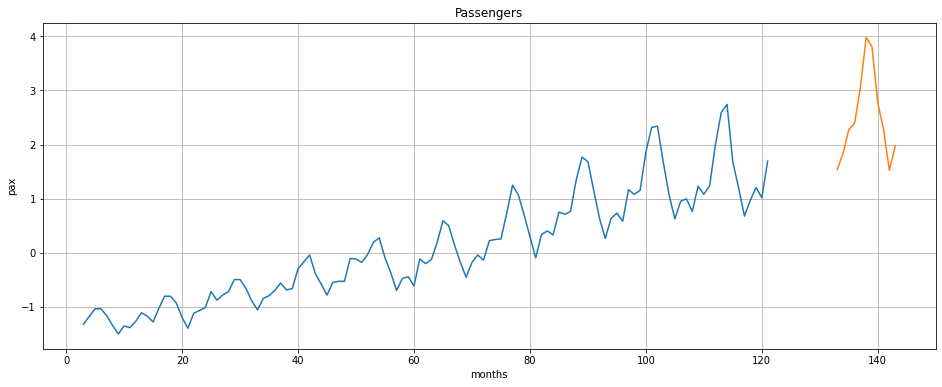

In [12]:
plt.figure(figsize=(16,6))
plt.plot(data_f.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data_f.index[yTrain.shape[0]+xLen+bias+future:],yVal[:])
plt.grid('on')
plt.xlabel('months')
plt.ylabel('pax')
plt.title('Passengers')
plt.show()

In [13]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)


In [14]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 3, 3)
Target shape: (32,)


In [15]:
inputs[2,:,0]

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([-1.05672038, -0.84518239, -0.79229789])>

In [16]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=-0.7922978939875214>

Epoch 1/30
4/4 [==============================] - 5s 313ms/step - loss: 0.8946 - mae: 0.8188 - val_loss: 6.7371 - val_mae: 2.4819
Epoch 2/30
4/4 [==============================] - 0s 30ms/step - loss: 0.6659 - mae: 0.7002 - val_loss: 5.1105 - val_mae: 2.1396
Epoch 3/30
4/4 [==============================] - 0s 31ms/step - loss: 0.4601 - mae: 0.5782 - val_loss: 3.0078 - val_mae: 1.5923
Epoch 4/30
4/4 [==============================] - 0s 30ms/step - loss: 0.2454 - mae: 0.4162 - val_loss: 0.9861 - val_mae: 0.7607
Epoch 5/30
4/4 [==============================] - 0s 31ms/step - loss: 0.1380 - mae: 0.2851 - val_loss: 0.3754 - val_mae: 0.5337
Epoch 6/30
4/4 [==============================] - 0s 32ms/step - loss: 0.1649 - mae: 0.3111 - val_loss: 0.3770 - val_mae: 0.5110
Epoch 7/30
4/4 [==============================] - 0s 30ms/step - loss: 0.1291 - mae: 0.2825 - val_loss: 0.6803 - val_mae: 0.5394
Epoch 8/30
4/4 [==============================] - 0s 34ms/step - loss: 0.0998 - mae: 0.2385 - va

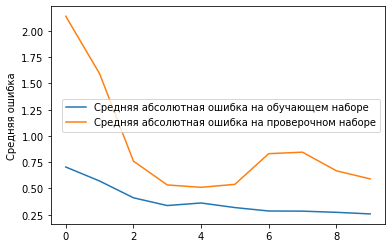

In [17]:
epochs=30

callback = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(64, return_sequences="True"))
model.add(Conv1D(128, 3, activation="linear"))
#model.add(Conv1D(128, 1, activation="linear"))
model.add(Flatten())
model.add(Dense(3, activation="linear"))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [18]:
hist_val = history.history['val_mae']
hist_train = history.history['mae']

Epoch 1/30
4/4 [==============================] - 0s 34ms/step - loss: 0.1146 - mae: 0.2590 - val_loss: 0.5924 - val_mae: 0.6109
Epoch 2/30
4/4 [==============================] - 0s 30ms/step - loss: 0.1086 - mae: 0.2525 - val_loss: 0.7205 - val_mae: 0.6655
Epoch 3/30
4/4 [==============================] - 0s 31ms/step - loss: 0.1012 - mae: 0.2377 - val_loss: 0.8971 - val_mae: 0.7214
Epoch 4/30
4/4 [==============================] - 0s 33ms/step - loss: 0.0977 - mae: 0.2300 - val_loss: 0.9356 - val_mae: 0.7533
Epoch 5/30
4/4 [==============================] - 0s 30ms/step - loss: 0.0929 - mae: 0.2236 - val_loss: 0.8569 - val_mae: 0.7655
Epoch 6/30
4/4 [==============================] - 0s 31ms/step - loss: 0.0909 - mae: 0.2233 - val_loss: 0.8228 - val_mae: 0.7785


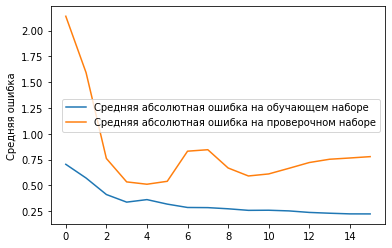

In [19]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callback])

hist_val.extend(history.history['val_mae'][:])
hist_train.extend(history.history['mae'][:])

plt.plot(hist_train[1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(hist_val[1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [20]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

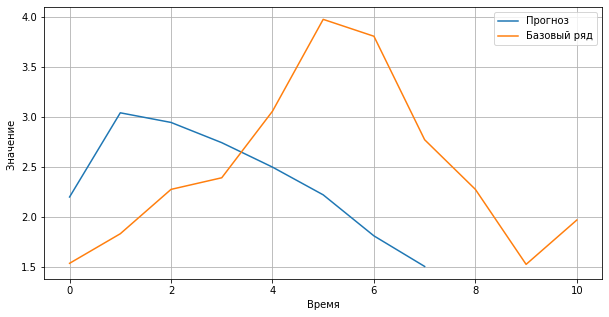

In [21]:
start = 0
step = 30
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[h+start:h+start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

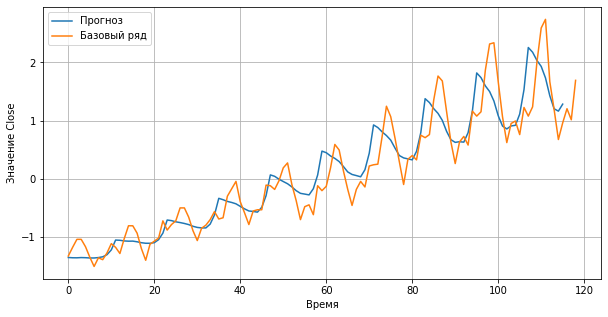

In [22]:
start = 0


plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[h+start:h+train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

Результат улучшился при увеличении тестовой выборки (120 вместо 100, как было изначально) и подбором параметров. 
прогноз улавливает (не сразу) суть тренда и в целом даже почти нет запаздывания. Однако пик колебаний модель не смогла повторить. 
Для дальнейшего улучшения качества не хватает данных в базе. 
